In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import pvlib as pv
import matplotlib.pyplot as plt

In [2]:
# get meteo file
FILENAME='DHTMY_SAM_E_9H23YU.csv' # set file to translate

# get latitude, longitude, utc and elevation
DATA=pd.read_csv(FILENAME,nrows=1)
latitude=DATA.iloc[0][5]
longitude=DATA.iloc[0][6]
UTC=-DATA.iloc[0][7]
ELEV=DATA.iloc[0][8]

# get meteorological variables
DATA=pd.read_csv(FILENAME,header=2)
YEAR=DATA['Year'].values
MONTH=DATA['Month'].values
DAY=DATA['Day'].values
HOUR=DATA['Hour'].values
GHI=DATA['GHI'].values
DNI=DATA['DNI'].values
DHI=DATA['DHI'].values
TDRY=DATA['Tdry'].values
TWET=DATA['Tdew'].values
RH=DATA['RH'].values
WS=DATA['Wspd'].values
WD=DATA['Wdir'].values

In [4]:
# get cloud coverage variabilty
# load coordinate matrices, X=LONG;Y=LAT

XCF=pd.read_csv('XCF.csv').values
YCF=pd.read_csv('YCF.csv').values

# load cloud coverage variability layer
CF=pd.read_csv('CF.csv').values

# calculate by interpolation the effective variability of cloud coverage
# for the target location

# Se reajustan las dimensiones de las matrices a arreglos de una dimensión
YCF=YCF.reshape(-1)
XCF=XCF.reshape(-1)
CF=np.array([CF.reshape(-1)]).T

# Se crea un arreglo de dos dimensiones donde cada entrada incluye latitud y longitud
XYCF=np.vstack((YCF,XCF)).T

# Se realiza una interpolación 
CFSTD=interpolate.griddata(XYCF, CF,(latitude,longitude),method='nearest')

In [5]:
# Calculate solar geometry
tz = f'Etc/GMT+{UTC}'
times = pd.date_range('2021-01-01 00:00:00', '2022-01-01', closed='left',
                      freq='H', tz=tz)
solpos = pv.solarposition.ephemeris(times, latitude, longitude)
elevationangle=solpos['elevation']


ast=solpos['solar_time']


# Extraterrestrial irradiance
epsilon=pv.solarposition.pyephem_earthsun_distance(times)
Io=np.maximum(0,1367*epsilon*np.sin(elevationangle*np.pi/180))


# Calculate clearness index and diffuse fraction

GHI=np.minimum(Io,GHI) #% limit GHI to under Io
Kt=GHI/Io
Kt[np.where(Io<=0)[0]]=0
DHI=np.minimum(DHI,GHI)# limit DHI to under GHI
K=np.minimum(1,DHI/GHI)
K[np.where(GHI<=0)[0]]=1
K[np.where(Io<=0)[0]]=1

In [6]:
# Load coefficients for BRL predictor generation

P=[[275.614845282659  ,-84.0341464533378  ,-1.86015047743254   ],
   [-123.987004786273 ,44.2818520840966   ,6.59582239895984    ],
   [-5.10707452673121 ,1.72451283166942   ,-0.163934905299144  ],
   [-1.06584246650315 ,0.243994275140034  ,-0.0184549284117407 ],
   [-81.5719886815895 ,20.4764911164922   ,2.22797398848424    ],
   [26.9296725403115  ,-6.13579726686233  ,0.360110809734099   ]]

# Calculate BRL predictors

B=[]
for i in range(0,6):
    B.append(P[i][0]*CFSTD**2+P[i][1]*CFSTD+P[i][2])

In [7]:
#Apply BRL model
# Calculate persistence

per=[]
UTCc=0

for counter in range(len(Kt)):
    if counter>=1 and counter<=(len(Kt)-2):
        if elevationangle[counter-1]<=0 and elevationangle[counter]>0:
            per.append(Kt[counter+1-UTCc])
            
        elif elevationangle[counter-1]>0 and elevationangle[counter]<=0:
            per.append(Kt[counter-1-UTCc])
            
        else:
            per.append(0.5*(Kt[counter+1-UTCc]+Kt[counter-1-UTCc]))
  
    else:
        per.append(0)


per=np.array(per)

In [8]:
# Calculate daily KT
KT=sum(GHI.values.reshape(24,int(len(GHI)/24)))/sum(Io.values.reshape(24,int(len(Io)/24)))
KT_aux=[]
for i in range(len(KT)):
    KT_aux.append(KT[i]*np.ones([24,1]))
KT_aux=np.array(KT_aux)
KT=KT_aux.reshape(-1)


#Apply model
Kbrl=(1/(1+np.exp(B[0]+B[1]*Kt+B[2]*ast+B[3]*elevationangle+B[4]*KT+B[5]*per)))

In [9]:
# Reconstruct irradiance
DHIbrl=Kbrl*Kt*Io # DHI by BRL reconstruction
DNIbrl=(GHI-DHIbrl)/np.sin(elevationangle*np.pi/180) # % DNI by BRL reconstruction
DNIbrl[np.where(elevationangle<=1)[0]]=0 # for very low solar elevations, make DNI=0 and GHI=DHI
DHIbrl[np.where(elevationangle<=1)[0]]=GHI[np.where(elevationangle<=1)[0]]

In [10]:
# Generate SHIPcal format file
OUT=pd.DataFrame(np.vstack((MONTH,DAY,HOUR,np.arange(1,len(GHI)+1),GHI,RH,WS,WD,DNIbrl,TDRY)).T)
OUT.to_csv(FILENAME.replace('csv','dat'), sep='\t',header=None)

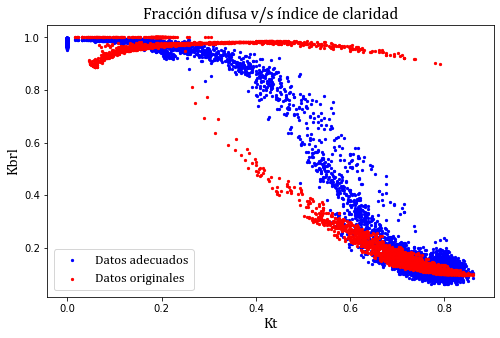

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(Kt,Kbrl,s=5,label='Datos adecuados',c='b')
plt.scatter(GHI/Io,DHI/GHI,s=5,label='Datos originales',c='r')

plt.title('Fracción difusa v/s índice de claridad', fontsize=16,name='Cambria')
plt.legend(prop={'family': 'Cambria','size':13})
plt.xlabel('Kt',fontsize=15,name='Cambria')
plt.ylabel('Kbrl',fontsize=15,name='Cambria')
plt.show()